### Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import numpy as np
import pandas as pd

%run classes/music.py
music = Music()

import warnings
warnings.filterwarnings('ignore')

# Decay

### Motivation

Sometimes we see sound that experiences some echo effect.  The loudness starts to decay, but than it bounces back after a short time period.

This is an issue because this can then be treated as two different notes!  We need some way to find the decay factor and use this to alleviate issues of double notes.

<br/>
<div style="float: left; width: 100%">
<img style="float: left;" src="photos/decay_1.png"></img>
</div>

<br/>
<div style="float: left; padding-left: 20px;">
(Figure 1: Image of an echo effect for one note)
</div>

### Making the curve

It's important to see how the volume decays over time.  One way of finding these characteristics is to track the moving average of the loudness of time.  If we fit an exponential curve to this we can view important properties like decay time.

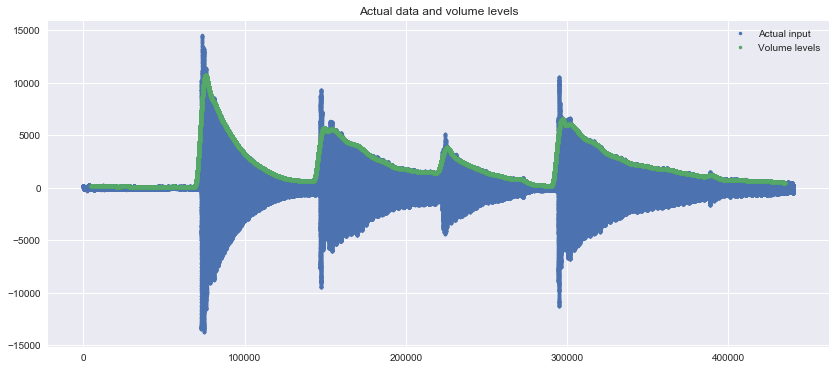

In [2]:
def get_max_curve(curve, window=100):
    max_curve = list()
    N         = len(curve)
    for i in range(N // window):
        start = i*window
        end   = (i*window) + window
        point = curve[start:end]
        point = max(point)
        max_curve.extend([point] * window)
    return np.array(max_curve)

music.read('sounds/wav/cello_pluck/multi/a3_d3_a3_d3.wav')
sound  = np.array(music.chan1)
volume = np.absolute(sound)
volume = get_max_curve(volume, window=500)
window = 5000
while window:
    volume = pd.rolling_mean(volume, window=window, center=True)
    window = int(window / 2)

plt.figure(figsize=(14, 6))
plt.plot(sound, ".", label="Actual input")
plt.plot(volume, ".", label="Volume levels")
plt.title("Actual data and volume levels")
plt.legend();

### Sample regions

There are four good regions to look at, shown below

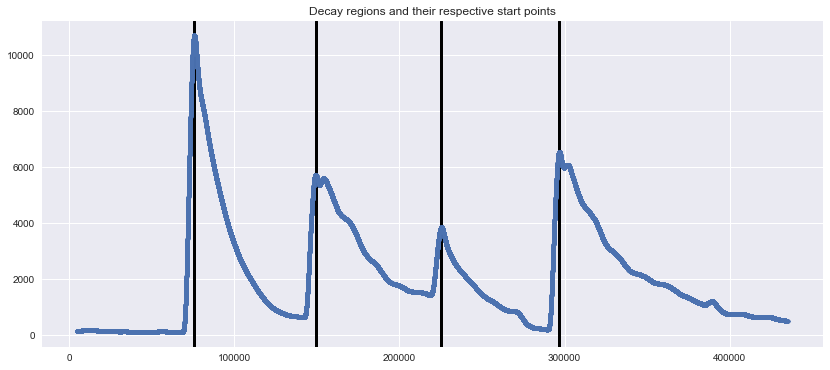

In [3]:
peaks = music.find_peaks(volume, separation=10000, min_volume_level=3000)

plt.figure(figsize=(14, 6))
for peak in peaks:
    plt.axvline(peak[0], color="k", linewidth=3)
    
plt.plot(volume, ".")
plt.title("Decay regions and their respective start points");

### Just choose the first one

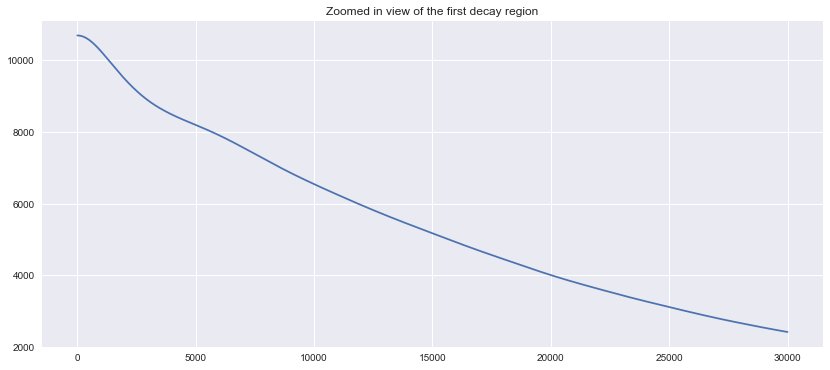

In [4]:
window = 30000
start  = peaks[0][0]

plt.figure(figsize=(14, 6))
region = volume[start:start+window]
plt.plot(region)
plt.title("Zoomed in view of the first decay region");

### Curve fitting

Interestingly we can see that at the very beginning of the note there are strong deviations from what is expected

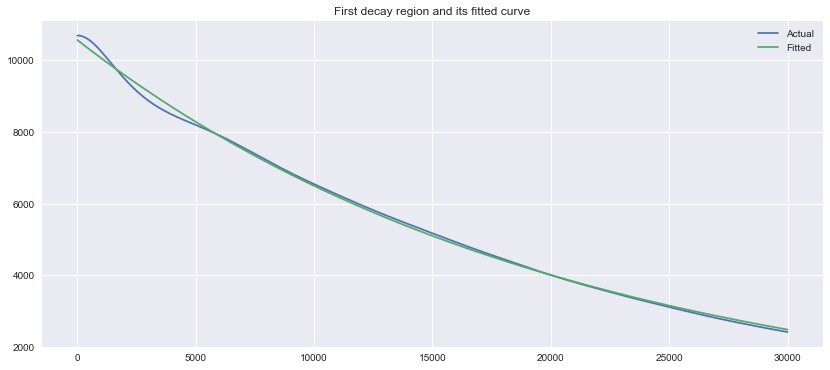

In [5]:
from scipy.optimize import curve_fit

def decay_curve(x, amplitude, lamb):
    return amplitude * np.exp(-lamb * x) + 8.56227564e+01

init_guess = [1.14823970e+04, 5.13209698e-05]
x = np.linspace(1, len(region), num=len(region))
popt, pcov = curve_fit(decay_curve, x, region, init_guess)
y = decay_curve(x, *popt)

plt.figure(figsize=(14, 6))
plt.plot(region, label="Actual")
plt.plot(y, label="Fitted")
plt.title("First decay region and its fitted curve")
plt.legend();

### Let's find the parameters for all four curves and see how they compare

Interesting, the decay factor (lambda) varies more than I expected

In [6]:
params    = ["Amplitude", "Lambda", "Region"]
params_df = pd.DataFrame(columns=params)

for i in range(4):
    window = 30000
    start  = peaks[i][0]
    region = volume[start:start+window]
    x = np.linspace(1, len(region), num=len(region))
    popt, _ = curve_fit(decay_curve, x, region, init_guess)
    params_df.loc[i] = list(popt)+[int(i+1)]
    
params_df["Region"] = params_df["Region"].map(int)
params_df

,Amplitude,Lambda,Region
0,10475.791274,0.000049,1
1,5887.030472,0.000021,2
2,3547.637494,0.000040,3
3,6552.850198,0.000024,4


### A final check for parameters

I want to choose a lambda value that will help determine if a volume is louder than what's allowed by physics.  (Sound volume will exponentially decrease.  If it is not, then a new note has been played!)

It looks like smaller lambda values are more conservative in terms of the decay rate.  The best choice would be to choose a lambda that's slightly smaller than the minimum value listed here

,Value
Average Lambda,0.000034
Maximum Lambda,0.000049
Minimum Lambda,0.000021


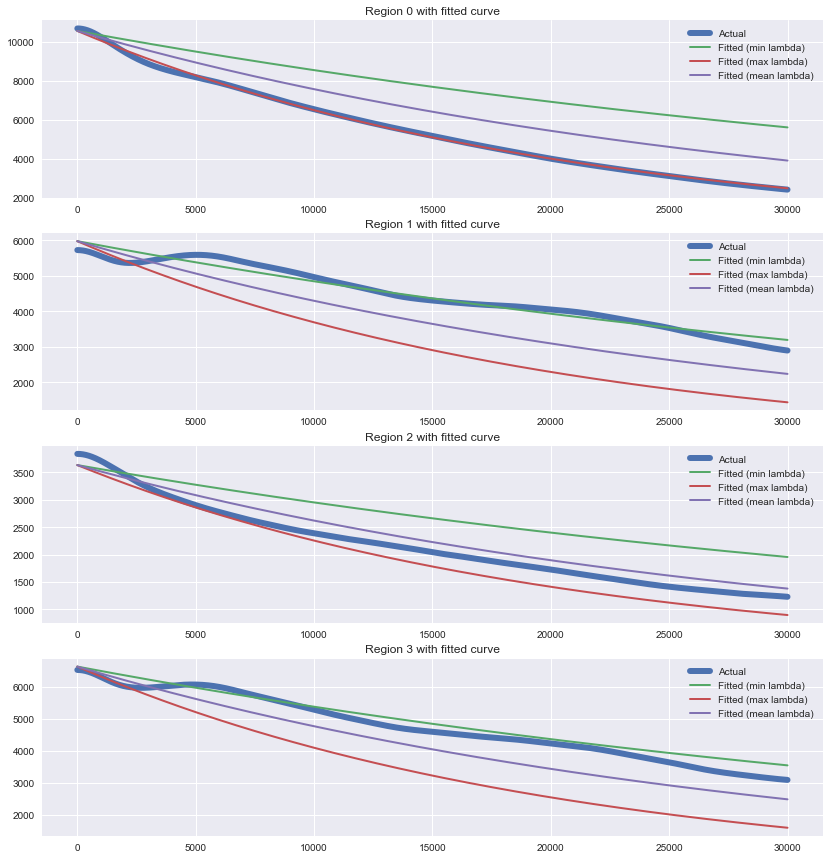

In [7]:
fig, axarr = plt.subplots(4, 1, figsize=(14, 15))

lamb_min  = params_df["Lambda"].min(axis=0)
lamb_max  = params_df["Lambda"].max(axis=0)
lamb_mean = params_df["Lambda"].mean(axis=0)

for i in range(4):
    window = 30000
    start  = peaks[i][0]
    region = volume[start:start+window]
    x = np.linspace(1, len(region), num=len(region))

    popt = [params_df.iloc[i]["Amplitude"], lamb_min]
    fitted_min = decay_curve(x, *popt)
    popt = [params_df.iloc[i]["Amplitude"], lamb_max]
    fitted_max = decay_curve(x, *popt)
    popt = [params_df.iloc[i]["Amplitude"], lamb_mean]
    fitted_mean = decay_curve(x, *popt)
    
    plt.figure(figsize=(14, 6))
    axarr[i].plot(region, label="Actual", linewidth=6)
    axarr[i].plot(fitted_min, label="Fitted (min lambda)", linewidth=2)
    axarr[i].plot(fitted_max, label="Fitted (max lambda)", linewidth=2)
    axarr[i].plot(fitted_mean, label="Fitted (mean lambda)", linewidth=2)
    axarr[i].set_title(f"Region {i} with fitted curve")
    axarr[i].legend();

lambs = pd.DataFrame({"Minimum Lambda": [lamb_min],
                       "Average Lambda": [lamb_mean],
                       "Maximum Lambda": [lamb_max]}).T
lambs.columns = ["Value"]
lambs